In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from fbprophet import Prophet
from datetime import datetime
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


In [4]:
df_original = pd.read_csv('../../data/raw/zillow_data.csv')

In [5]:
twentyyear = list(df_original[df_original['1998-04'].isna() != True]['RegionName'])

In [6]:
with open('../../data/processed/prophet_lists_wyatt2', 'rb') as p:
    wyatt = pickle.load(p)
with open('../../data/processed/prophet_lists_brent', 'rb') as fp:
    brent = pickle.load(fp)
with open('../../data/processed/prophet_lists_kw', 'rb') as kp:
    karen = pickle.load(kp)
with open('../../data/processed/prophet_lists_forgotten', 'rb') as bp:
    forgotten = pickle.load(bp)

In [7]:
wyatt.extend(brent)
wyatt.extend(karen)
wyatt.extend(forgotten)
df_summary = pd.DataFrame(wyatt)

In [8]:
df_summary.nlargest(5, 'pct_change_1year')

,Zipcode,estimate_1year,upper_1year,lower_1year,pct_change_1year,estimate_5year,upper_5year,lower_5year,gross_profit_1year,pct_change_5year,gross_profit_5year
12507,46320,95849.902058,100795.718772,91098.799182,42.633783,130633.724585,152049.952306,109311.078551,28649.902058,94.395423,63433.724585
10484,38614,116391.321982,123072.796244,109458.515726,38.067998,148210.284709,165646.983748,131317.894423,32091.321982,75.812912,63910.284709
9230,29405,146053.837988,156042.437150,135666.988450,35.360369,270983.148667,361850.835985,177848.255129,38153.837988,151.142863,163083.148667
4867,56120,179342.942320,186781.227864,172102.730021,34.238729,283815.406832,336910.908211,234621.810005,45742.942320,112.436682,150215.406832
2511,56062,211221.855924,219101.132779,202962.432811,33.178976,334591.745519,390339.478828,276764.817079,52621.855924,110.965792,175991.745519


In [9]:
df_summary.nlargest(5, 'gross_profit_1year')

,Zipcode,estimate_1year,upper_1year,lower_1year,pct_change_1year,estimate_5year,upper_5year,lower_5year,gross_profit_1year,pct_change_5year,gross_profit_5year
5193,10021,2.241481e+07,2.445010e+07,2.034373e+07,25.258100,2.656084e+07,2.905512e+07,2.412499e+07,4.519912e+06,48.426847,8.665936e+06
4941,10011,1.292164e+07,1.351323e+07,1.238543e+07,12.574533,1.406967e+07,1.659180e+07,1.170316e+07,1.443343e+06,22.576249,2.591370e+06
5429,10014,1.016229e+07,1.100309e+07,9.375966e+06,13.427269,9.823399e+06,1.114156e+07,8.529984e+06,1.202989e+06,9.644716,8.640990e+05
4942,10128,8.252667e+06,9.208156e+06,7.282725e+06,11.724842,9.049291e+06,1.002256e+07,7.976592e+06,8.660672e+05,22.509564,1.662691e+06
3342,94957,3.665572e+06,3.902048e+06,3.408875e+06,24.281943,4.414721e+06,5.007573e+06,3.771396e+06,7.161716e+05,49.681988,1.465321e+06


In [10]:
df_summary.nlargest(5, 'gross_profit_5year')

,Zipcode,estimate_1year,upper_1year,lower_1year,pct_change_1year,estimate_5year,upper_5year,lower_5year,gross_profit_1year,pct_change_5year,gross_profit_5year
5193,10021,2.241481e+07,2.445010e+07,2.034373e+07,25.258100,2.656084e+07,2.905512e+07,2.412499e+07,4.519912e+06,48.426847,8.665936e+06
435,94027,7.185297e+06,7.406351e+06,6.966912e+06,5.720550,9.463072e+06,1.134937e+07,7.707219e+06,3.887972e+05,39.234486,2.666572e+06
4941,10011,1.292164e+07,1.351323e+07,1.238543e+07,12.574533,1.406967e+07,1.659180e+07,1.170316e+07,1.443343e+06,22.576249,2.591370e+06
9737,90210,6.273671e+06,6.461362e+06,6.077476e+06,5.321245,8.314621e+06,9.932465e+06,6.404880e+06,3.169706e+05,39.584357,2.357921e+06
9644,33480,5.200459e+06,5.389460e+06,5.003213e+06,10.973898,6.580330e+06,8.304750e+06,4.834230e+06,5.142588e+05,40.419318,1.894130e+06


In [11]:
topfive = list(df_summary[df_summary['Zipcode'].isin(twentyyear)].nlargest(5, 'pct_change_5year')['Zipcode'])

## Next Steps
- Rerun prophet analyses with cross-validation for top 5 of each
- Plot forecasts
- Rerun with ARMA/ARIMA/SARIMA for top 5

In [12]:
def one_zipcode(df, zipcode, index = None):
    """This function pulls the data for one zipcode at a time and retuns a DataFrame for using in Prophet."""
    if index != None:
        series = df.iloc[index]
    else:
        series = df.loc[df['RegionName'] == zipcode]
        series = series.iloc[0]
    series_data = series.iloc[7:]
    df_series = pd.DataFrame(series_data.values, index = series_data.index, columns = ['y'])
    df_series.index = pd.to_datetime(df_series.index, yearfirst = True, format = '%Y-%m')
    df_series['ds'] = df_series.index
    df_series.reset_index(drop = True, inplace = True)
    df_series['y'] = df_series['y'].astype('int64', errors='ignore')
    return df_series

In [13]:
def Prophet_analysis(df):
    """This function instantiates a Prophet model, fits it to the DataFrame, and predicts values which are returned in 
    a forecast Dataframe."""
    m = Prophet(seasonality_mode='multiplicative', interval_width=0.95)
    m.fit(df)
    future = m.make_future_dataframe(60, freq = 'M')
    forecast = m.predict(future)
    return m, forecast

In [14]:
def cross_validate(m):
    df_cv = cross_validation(m, initial = '10 Y', horizon = '12 M')
    return df_cv

In [15]:
def rmse(y, yhat):
    return np.sum((np.array(y)-np.array(yhat))**2/len(y))**(1/2)    

In [16]:
def plot_forecast(m, forecast, df_original, zipcode, df_summary, df_cv):
    """This function plots and saves the figure of the five year forecast from Prophet."""
    fig = m.plot(forecast)
    city = list(df_original[df_original['RegionName'] == zipcode]['City'])[0]
    state = list(df_original[df_original['RegionName'] == zipcode]['State'])[0]
    oneyearperc = round(list(df_summary[df_summary['Zipcode'] == zipcode]['pct_change_1year'])[0], 2)
    oneyearest = round(list(df_summary[df_summary['Zipcode'] == zipcode]['estimate_1year'])[0])
    fiveyearperc = round(list(df_summary[df_summary['Zipcode'] == zipcode]['pct_change_5year'])[0], 2)
    fiveyearest = round(list(df_summary[df_summary['Zipcode'] == zipcode]['estimate_5year'])[0])
    current_price = list(df_original[df_original['RegionName'] == zipcode]['2018-04'])[0]
    RMSE = round(rmse(df_cv['y'], df_cv['yhat']), 2)
    plt.title(f"Five year forecast of median home sale price for {city}, {state}, {zipcode} \n Current Price (as of April 2018): ${current_price} \n One Year Estimate: ${oneyearest} (Percent Growth: {oneyearperc}%) \n Five Year Estimate: ${fiveyearest} (Percent Growth: {fiveyearperc}%) \n RMSE: {RMSE}")
    plt.xlim(left = one_zipcode(df_original, zipcode = zipcode, index = None).dropna().iloc[0,1], right = pd.to_datetime('2023-06-01 00:00:00'))
    plt.ylim(0)
    #plt.vlines(x = pd.to_datetime('2018-04', yearfirst = True, format = '%Y-%m'), ymin = 0, ymax = forecast['yhat_upper'].max(), linestyles = 'dashed', label = f"Current Price: {current_price}")
    plt.xlabel('Date')
    plt.ylabel('Median Home Sale Price')
    plt.tight_layout()
    #plt.legend(loc = 'center right')
    plt.savefig(f"../../figures/5yearforecast_{city}_{zipcode}", dpi = 200)
    

In [17]:
def prophet_cross_validate_and_plot(zipcodes, df_original, df_summary):
    for x in zipcodes:
        df = one_zipcode(df_original, zipcode = x)
        m, forecast = Prophet_analysis(df)
        df_cv = cross_validate(m)
        plot_forecast(m, forecast, df_original, zipcode = x, df_summary = df_summary, df_cv = df_cv)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/opt/anaconda3/envs/zipcode/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
INFO:fbprophet:Making 144 forecasts with cutoffs between 2006-04-30 23:48:00 and 2018-03-31 23:48:00
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 144 forecasts with cutoffs between 2006-04-30 23:48:00 and 2018-03-31 23:48:00
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=

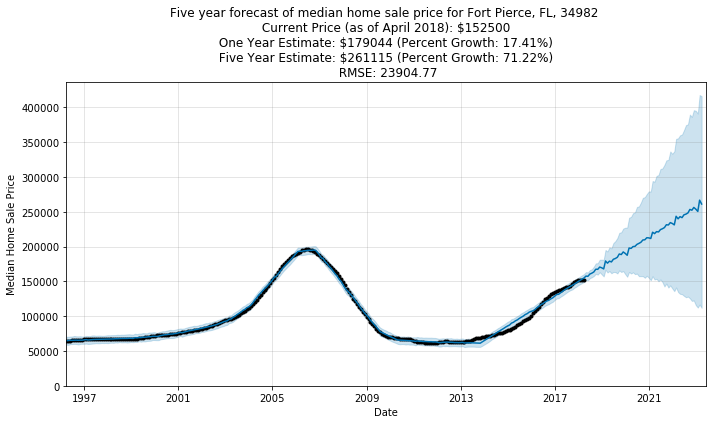

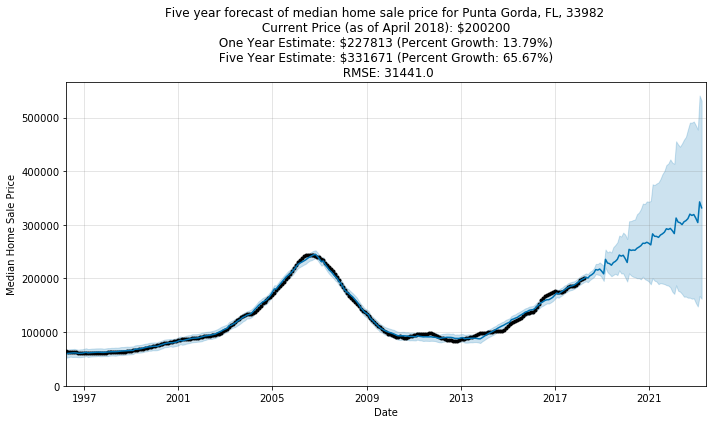

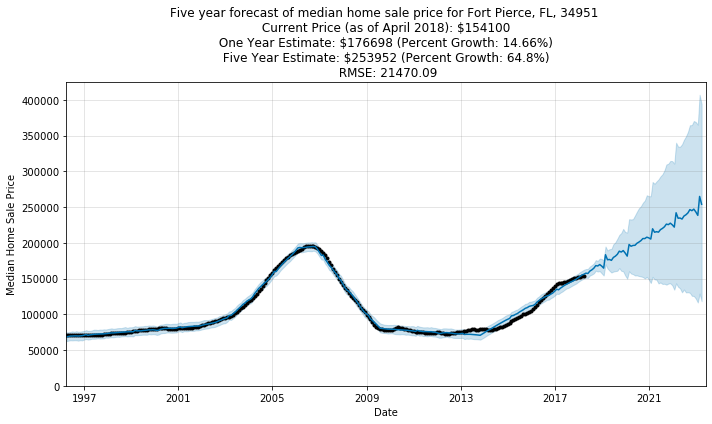

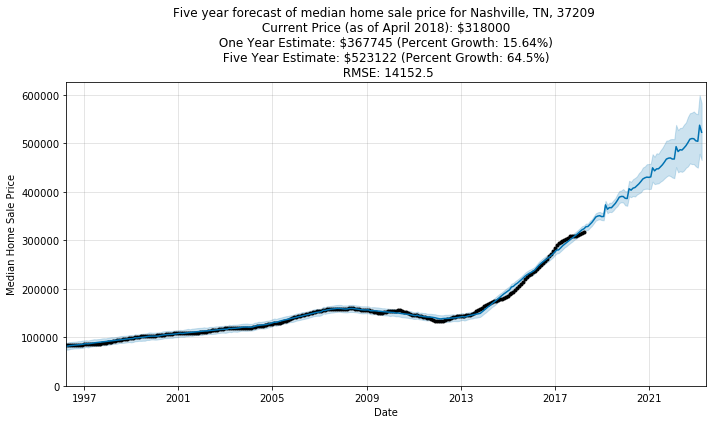

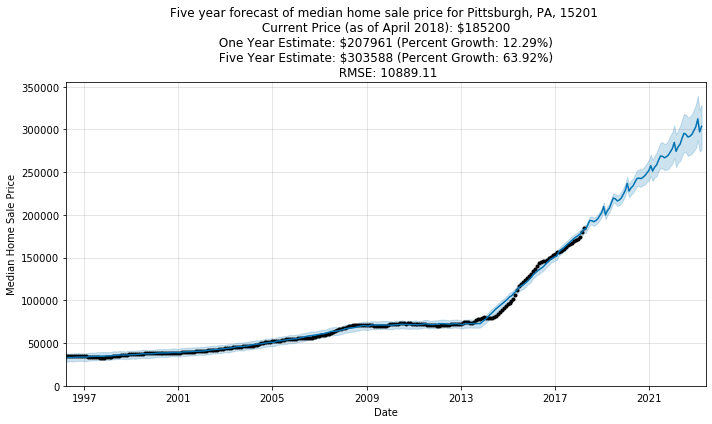

In [259]:
prophet_cross_validate_and_plot(topfive, df_original, df_summary)